In [1]:
import data_smoothing
import find_peaks
import peak_character
import peak_classify
import feature_visualizer

# Load real TA data

In [2]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp03_20180103 -t0 -chirp.csv')

# Smoothen data

In [3]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


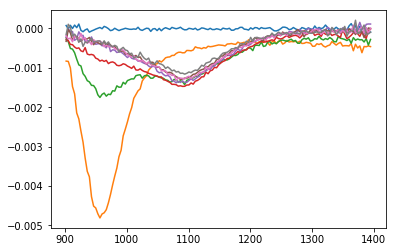

In [15]:
import matplotlib.pyplot as plt
plt.plot(data_nm, data_z[:,1::100])

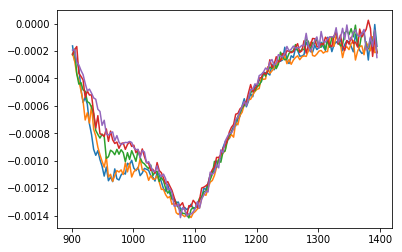

In [46]:
plt.plot(data_nm, data_z[:,250:300:10])

# Find peaks

In [24]:
threshold = 0.75
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

In [25]:
idx.describe()

,0,1
count,725.000000,63.000000
mean,46.542069,54.809524
std,19.058139,12.559352
min,5.000000,29.000000
25%,23.000000,52.000000
50%,56.000000,53.000000
75%,56.000000,54.000000
max,136.000000,130.000000


In [26]:
height.describe()

,0,1
count,725.000000,63.000000
mean,-0.001489,-0.001263
std,0.000716,0.000295
min,-0.004840,-0.001424
25%,-0.001424,-0.001356
50%,-0.001322,-0.001323
75%,-0.001213,-0.001290
max,0.000106,0.000092


In [27]:
fwhm.describe()

,0,1
count,725.000000,63.000000
mean,175.291306,157.402667
std,48.004411,39.672537
min,37.652000,24.340000
25%,161.780000,148.090000
50%,168.643000,154.980000
75%,189.251000,161.830000
max,462.422000,428.362000


# convert peak index to nm

In [5]:
import numpy as np
idx_np = np.nan_to_num(np.array(idx))

peak1 = np.empty(len(data_time))
peak2 = np.empty_like(peak1)
for i in range(np.shape(idx_np)[0]):
    peak1[i] = data_nm[int(idx_np[:, 0][i])]
    peak2[i] = data_nm[int(idx_np[:, 1][i])]

In [6]:
import remove_outlier as outlier
import matplotlib.pyplot as plt

In [7]:
peak1_corr = outlier.id_outliers_replacewith_interp(data_time, peak1, 1, 50)

15


In [8]:
peak1_isotonic = outlier.isotonic(data_time, peak1_corr)

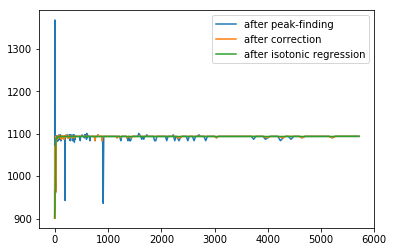

In [9]:
plt.figure()

plt.plot(data_time, peak1, label = 'after peak-finding')
plt.plot(data_time, peak1_corr, label = 'after correction')
plt.plot(data_time, peak1_isotonic, label = 'after isotonic regression')
plt.legend()

In [26]:
np.shape(peak1_corr)

(786,)

In [35]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    corrected_output = all_points.fillna(value=0)
    
    return corrected_output

def cluster_classifier(index_df, corrected_output):
    found_peak = 2
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-1])
    print(cluster.labels_)
    peak_dict = {}
    
    for i in range(found_peak):
            peak_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-1]])
        signal = corrected_output.loc[j][1]
        for k in range(found_peak):
            if (peak == k):
                peak_dict['peak_%s' % k].append(corrected_output.values[j])
                print('found a match')

    return peak_dict

In [45]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output.describe()

,Position,Height,Width,Time
count,1572.000000,1572.000000,1572.000000,1572.000000
mean,23.661578,-0.000737,87.151759,392.500000
std,27.083528,0.000885,93.260956,226.970675
min,0.000000,-0.004840,0.000000,0.000000
25%,0.000000,-0.001323,0.000000,196.000000
50%,9.000000,0.000000,49.642500,392.500000
75%,55.000000,0.000000,168.643000,589.000000
max,136.000000,0.000106,462.422000,785.000000


In [37]:
df = corrected_output.drop(corrected_output[abs(corrected_output.Height) < 0.001].index)

In [38]:
df = df.reset_index(drop=True)
df.describe()

,Position,Height,Width,Time
count,758.000000,758.000000,758.000000,758.000000
mean,46.616095,-0.001526,173.460897,420.346966
std,15.826223,0.000647,40.283201,201.244542
min,15.000000,-0.004840,75.358000,88.000000
25%,52.000000,-0.001417,161.780000,240.000000
50%,55.000000,-0.001330,168.643000,406.500000
75%,56.000000,-0.001236,185.791000,595.750000
max,58.000000,-0.001056,271.612000,785.000000


In [39]:
peak_dict = cluster_classifier(idx, df)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found 

In [40]:
peak_dict

{'peak_0': [array([ 1.70000000e+01, -1.14855473e-03,  8.22220000e+01,  8.80000000e+01]),
  array([ 1.50000000e+01, -1.35168345e-03,  7.53580000e+01,  8.90000000e+01]),
  array([ 1.60000000e+01, -1.15429522e-03,  7.87790000e+01,  9.00000000e+01]),
  array([ 1.6000000e+01, -1.7169881e-03,  8.2210000e+01,  9.1000000e+01]),
  array([ 1.60000000e+01, -2.15622905e-03,  8.22100000e+01,  9.20000000e+01]),
  array([ 1.60000000e+01, -2.08215655e-03,  8.22100000e+01,  9.30000000e+01]),
  array([ 1.60000000e+01, -2.29601804e-03,  7.87890000e+01,  9.40000000e+01]),
  array([ 1.60000000e+01, -2.33097727e-03,  7.87890000e+01,  9.50000000e+01]),
  array([ 1.70000000e+01, -3.28291508e-03,  7.88020000e+01,  9.60000000e+01]),
  array([ 1.60000000e+01, -3.17960645e-03,  7.53690000e+01,  9.70000000e+01]),
  array([ 1.60000000e+01, -3.04087113e-03,  8.22320000e+01,  9.80000000e+01]),
  array([ 1.60000000e+01, -4.13126969e-03,  7.88020000e+01,  9.90000000e+01]),
  array([ 1.60000000e+01, -4.07442793e-03,  7.

In [48]:
import numpy as np
np.array(peak_dict['peak_0'])[300,:]

array([ 5.60000000e+01, -1.39774835e-03,  1.61780000e+02,  4.87000000e+02])

In [49]:
data_nm[56]

1093.69

In [43]:
peak_dict2 = cluster_classifier(idx, corrected_output)
peak_dict2

[1 1 1 ... 1 0 1]
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
fo

found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found 

found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found 

{'peak_0': [array([ 1.35000000e+02, -4.10804878e-05,  2.45950000e+02,  7.00000000e+00]),
  array([ 3.80000000e+01, -3.34943323e-05,  2.96004000e+02,  1.20000000e+01]),
  array([1.29000000e+02, 4.80442764e-05, 1.83930000e+02, 1.60000000e+01]),
  array([ 3.3000000e+01, -2.7309014e-05,  1.8550200e+02,  1.9000000e+01]),
  array([ 3.80000000e+01, -3.72733405e-05,  1.61673000e+02,  3.60000000e+01]),
  array([ 2.40000000e+01, -4.21982093e-05,  1.40872000e+02,  4.00000000e+01]),
  array([ 1.2000000e+02, -3.2778491e-05,  1.2477000e+02,  4.3000000e+01]),
  array([ 1.07000000e+02, -4.59567864e-05,  1.97380000e+02,  4.70000000e+01]),
  array([ 3.30000000e+01, -7.51163493e-05,  1.37370000e+02,  4.80000000e+01]),
  array([ 3.00000000e+01, -7.51473984e-05,  1.13194000e+02,  4.90000000e+01]),
  array([1.14000000e+02, 7.24402578e-05, 4.20573000e+02, 5.70000000e+01]),
  array([ 1.3300000e+02, -3.5509337e-05,  1.2507000e+02,  5.8000000e+01]),
  array([1.3100000e+02, 7.7061901e-05, 4.6218200e+02, 6.600000

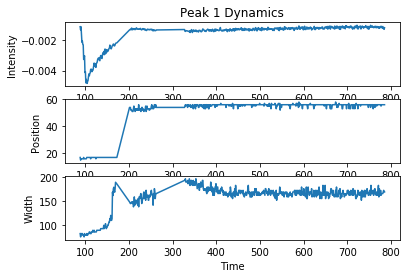

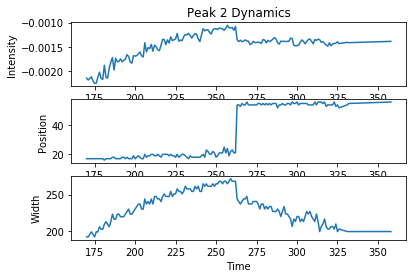

In [41]:
output = feature_visualizer.visualize(peak_dict)

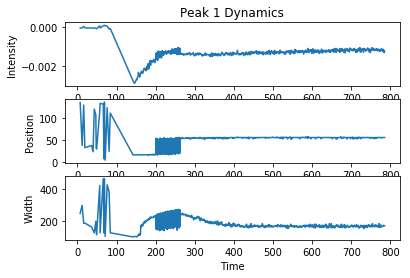

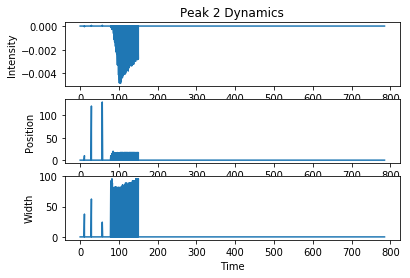

In [44]:
output2 = feature_visualizer.visualize(peak_dict2)

# peak #2

In [14]:
peak2_corr = outlier.id_outliers_replacewith_interp(data_time, peak2, 1, 100)

7


In [15]:
peak2_isotonic = outlier.isotonic(data_time, peak2_corr)

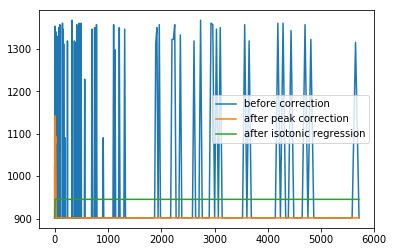

In [16]:
plt.figure()
plt.plot(data_time, peak2, label = 'before correction')
plt.plot(data_time, peak2_corr, label = 'after peak correction')
plt.plot(data_time, peak2_isotonic, label = 'after isotonic regression')
plt.legend()

In [16]:
height.describe()

,0,1,2,3,4
count,760.000000,224.000000,26.000000,8.000000,1.000000
mean,-0.001416,-0.000759,-0.000068,0.000013,0.000016
std,0.000766,0.000620,0.000129,0.000055,NaN
min,-0.004840,-0.001438,-0.000357,-0.000065,0.000016
25%,-0.001415,-0.001310,-0.000044,-0.000021,0.000016
50%,-0.001309,-0.001200,-0.000019,0.000007,0.000016
75%,-0.001199,-0.000029,0.000006,0.000042,0.000016
max,0.000084,0.000092,0.000072,0.000106,0.000016


In [ ]:
peak_dict